# Traditional Programming vs Machine Learning

R Yeeshu Dhurandhar, Rahul Chembakasseril  
2024-01-04

In [1]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from latexify import latexify
import seaborn as sns
%matplotlib inline
# config retina
%config InlineBackend.figure_format = 'retina'

In [2]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Load MNIST dataset
mnist_train = torchvision.datasets.MNIST('../datasets', train=True, transform=torchvision.transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST('../datasets', train=False, transform=torchvision.transforms.ToTensor(), download=True)

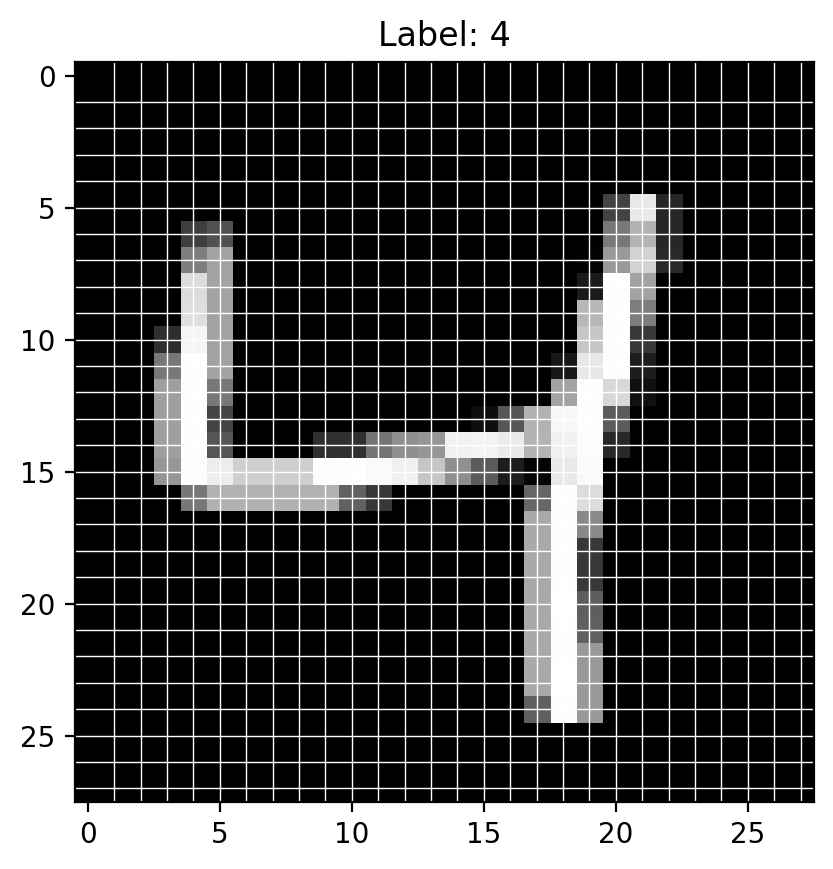

In [4]:

# Function to show a digit marking 28x28 grid with arrows pointing to random pixels
def show_digit_with_arrows(digit, label=None):
    fig, ax = plt.subplots()
    digit = digit.numpy().reshape(28, 28)

    # Display the digit
    ax.imshow(digit, cmap='gray')

    # Add gridlines corresponding to 28 rows and columns
    for i in range(1, 28):
        ax.axhline(i, color='white', linewidth=0.5)
        ax.axvline(i, color='white', linewidth=0.5)

    # Display label if available
    if label is not None:
        ax.set_title(f'Label: {label}')
    return fig, ax


index = 2
# Show a random digit with arrows pointing to random 10 pixels
fig, ax = show_digit_with_arrows(*mnist_train[index])
# save figure
fig.savefig("../figures/mnist.pdf", bbox_inches='tight')

In [6]:
# Find indices of digit 4 in the training set
digit_4_indices_train = torch.where(torch.tensor(mnist_train.targets) == 4)[0]
digit_4_indices_test = torch.where(torch.tensor(mnist_test.targets) == 4)[0]

print(f"Indices of digit 4 in Train dataset: {digit_4_indices_train}")
print(f"Number of digit 4 images in training set: {len(digit_4_indices_train)}\n")

Indices of digit 4 in Train dataset: tensor([    2,     9,    20,  ..., 59943, 59951, 59975])
Number of digit 4 images in training set: 5842


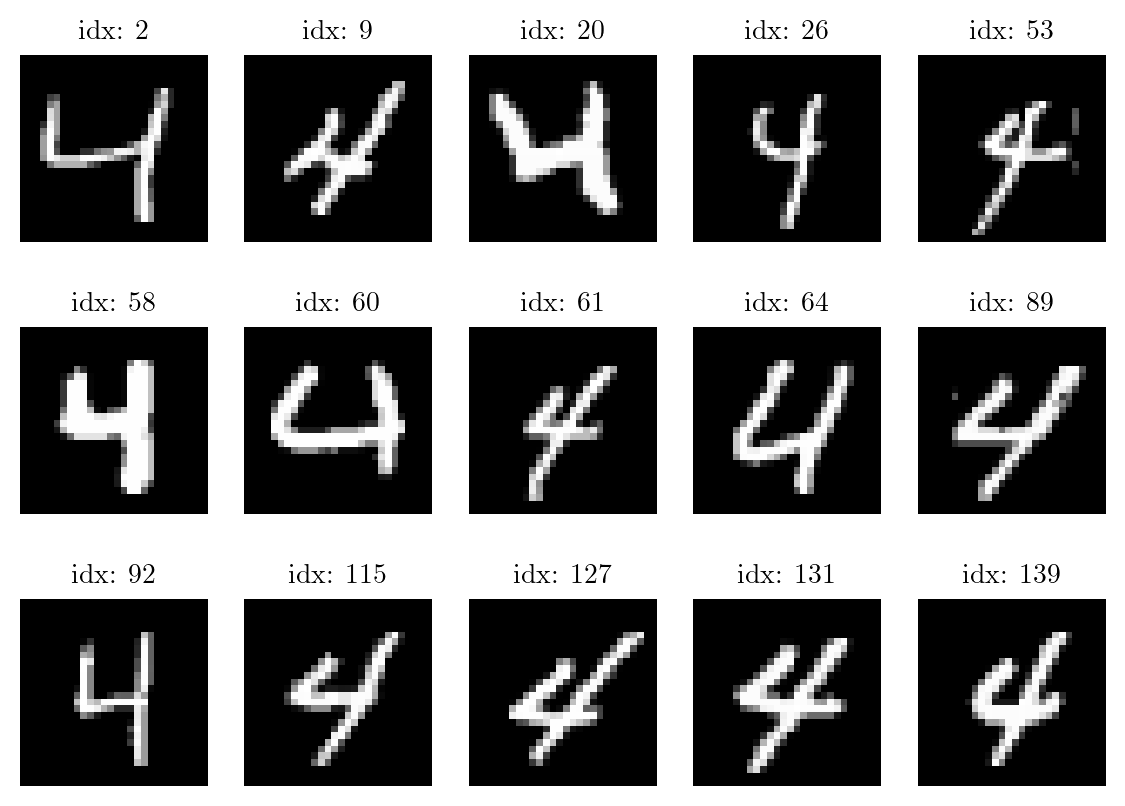

In [7]:
latexify(fig_width=7, fig_height=5)

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(mnist_train.data[digit_4_indices_train[i]], cmap='gray')
    plt.title(f"idx: {digit_4_indices_train[i]}")
    plt.axis('off')

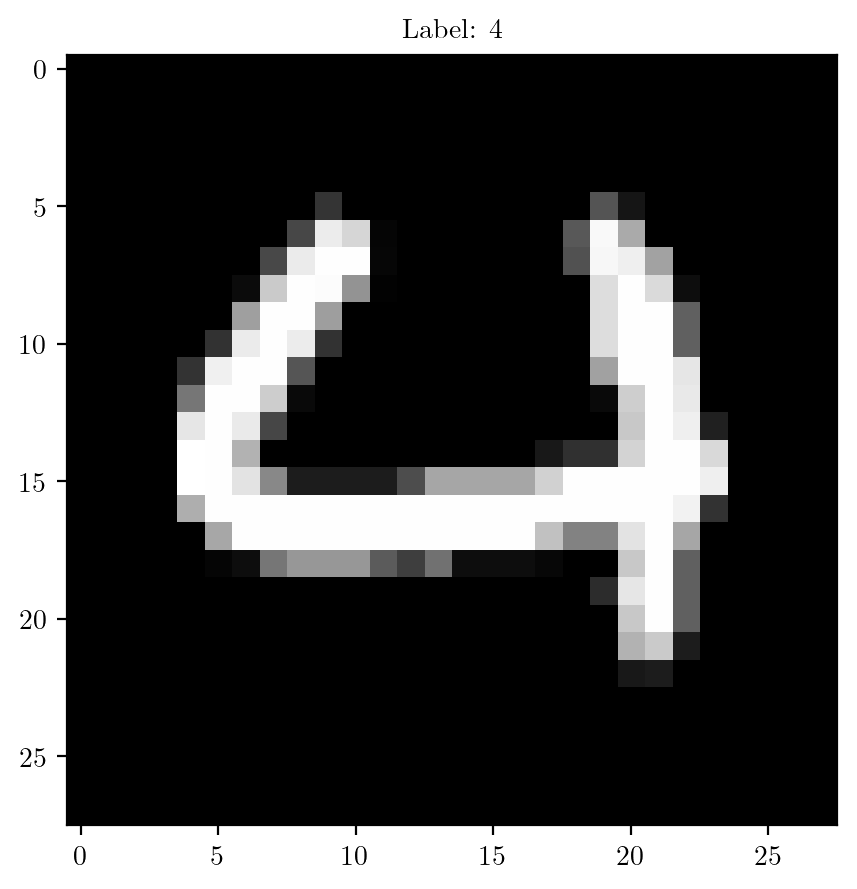

In [10]:
# Select a sample from the training set
sample_idx_1 = 60
image, label = mnist_train[sample_idx_1]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [11]:
# Function to extract edges based on intensity threshold
def extract_edges(image, threshold=0.1):
    '''
    Input:
        image: torch.tensor of shape (28, 28)
        threshold: (float) the minimum intensity value to be considered as white pixel
    '''
    edges = torch.zeros_like(image)

    # converting all the pixels with intensity greater than threshold to white
    edges[image > threshold] = 1.0
    return edges

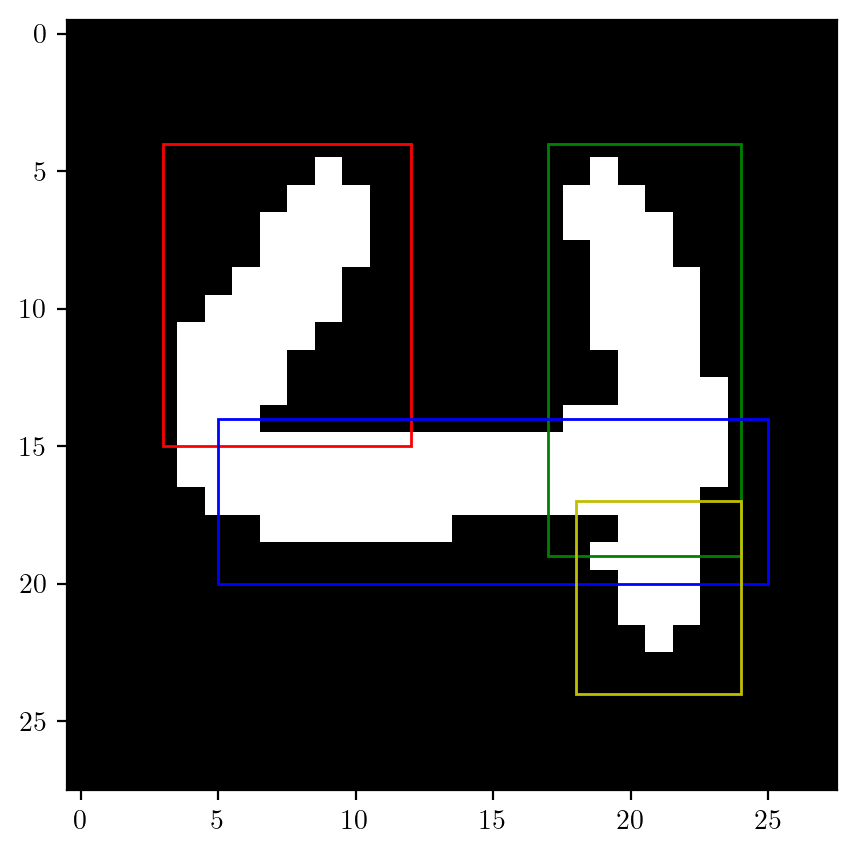

In [21]:
# Creating rules based upon one image
edges = extract_edges(image)

plt.imshow(edges[0, :, :], cmap='gray')

# finding areas of edges
left_edge_train = edges[:, 4:15, 3:12]
upper_right_edge_train = edges[:, 4:19, 17:24]
middle_edge_train = edges[:, 14:20, 5:25]
lower_right_edge_train = edges[:, 17:24, 18:24]


# R1 (4-15, 3-12)
r1 = plt.Rectangle((3, 4), 9, 11, linewidth=1, edgecolor='r', facecolor='none')
r2 = plt.Rectangle((17, 4), 7, 15, linewidth=1, edgecolor='g', facecolor='none')
r3 = plt.Rectangle((5, 14), 20, 6, linewidth=1, edgecolor='b', facecolor='none')
r4 = plt.Rectangle((18, 17), 6, 7, linewidth=1, edgecolor='y', facecolor='none')
for rect in [r1, r2, r3, r4]:
    plt.gca().add_patch(rect)



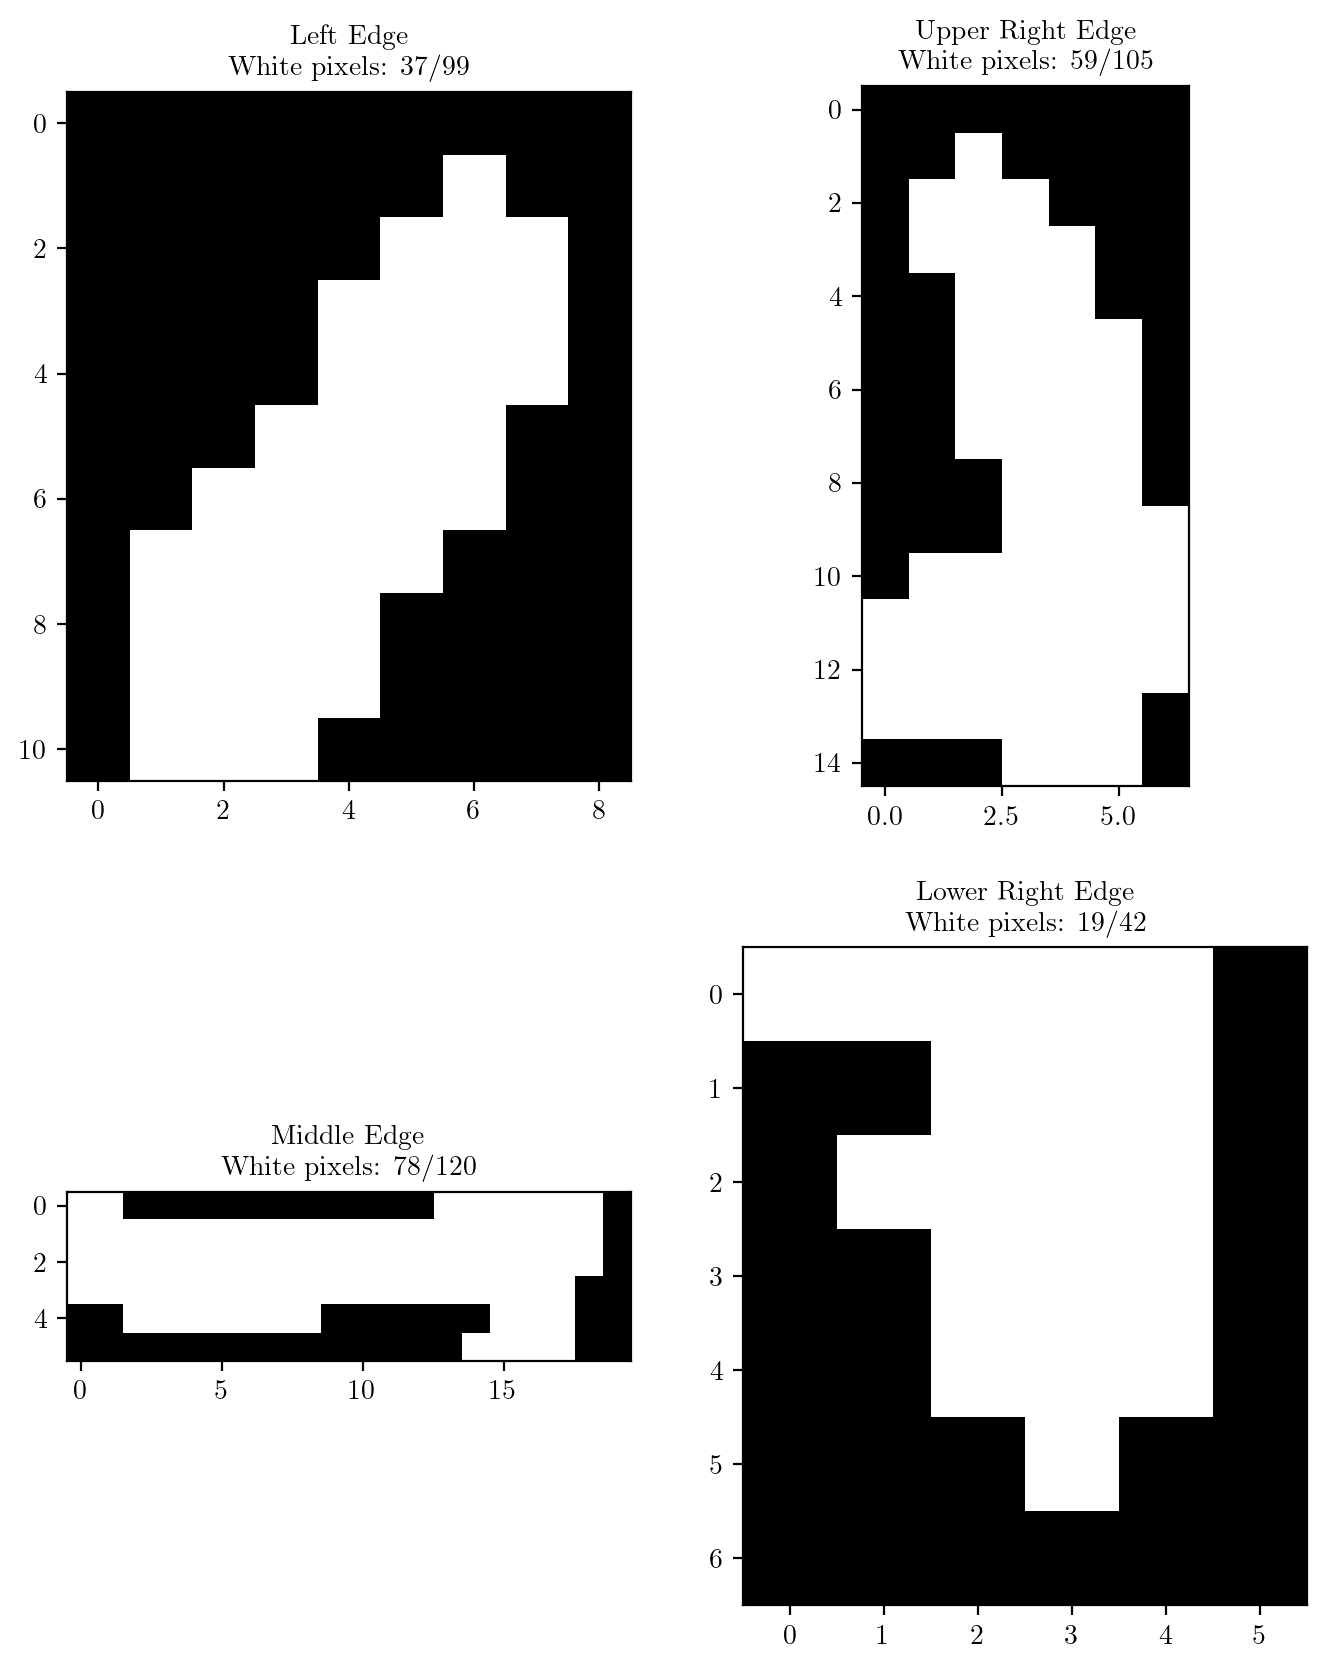

In [22]:
# creat a subplot 2 rows by 2 columns
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# plotting the images
axs[0, 0].imshow(left_edge_train.squeeze().numpy(), cmap='gray')
axs[0, 1].imshow(upper_right_edge_train.squeeze().numpy(), cmap='gray')
axs[1, 0].imshow(middle_edge_train.squeeze().numpy(), cmap='gray')
axs[1, 1].imshow(lower_right_edge_train.squeeze().numpy(), cmap='gray')

axs[0, 0].set_title(f"Left Edge\nWhite pixels: {int(left_edge_train.sum())}/{left_edge_train.numel()}")
axs[0, 1].set_title(f"Upper Right Edge\nWhite pixels: {int(upper_right_edge_train.sum())}/{upper_right_edge_train.numel()}")
axs[1, 0].set_title(f"Middle Edge\nWhite pixels: {int(middle_edge_train.sum())}/{middle_edge_train.numel()}")
axs[1, 1].set_title(f"Lower Right Edge\nWhite pixels: {int(lower_right_edge_train.sum())}/{lower_right_edge_train.numel()}")

plt.show()

In [23]:
# Rule-based digit classifier for digit 4
def rule_based_classifier(image):
    # Extract edges
    edges = extract_edges(image)

    # Define rules for digit 4 based on the edges of the digit
    left_edge = edges[:, 4:15, 3:12]
    upper_right_edge = edges[:, 4:19, 17:24]
    middle_edge = edges[:, 14:20, 5:25]
    lower_right_edge = edges[:, 17:24, 18:24]

    # Check if all required edges are present by checking the number of white pixels for each edge.
    # The number of white pixels for each edge is 'sub' less than the number of pixels in the edge for the above take digit.
    sub = 10
    if torch.sum(left_edge) > left_edge_train.sum() - sub and torch.sum(upper_right_edge) > upper_right_edge_train.sum() - sub and torch.sum(middle_edge) > middle_edge_train.sum() - sub and torch.sum(lower_right_edge) > lower_right_edge_train.sum() - sub:
        return 4
    else:
        return -1 # -1 indicates that the digit is not 4

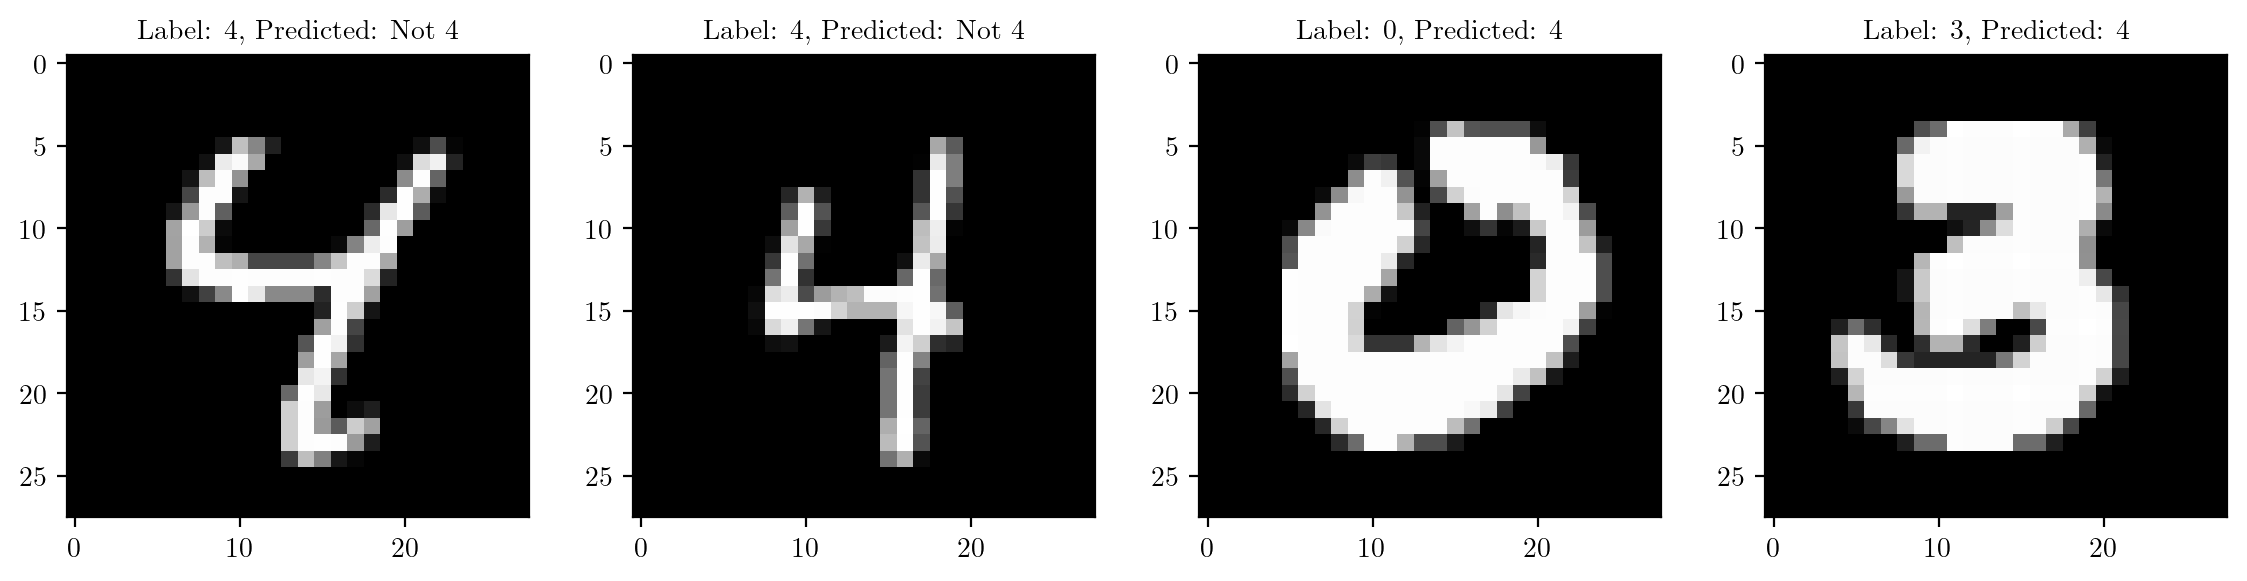

In [24]:
# Display some wrongly classified images

indices = [6, 19, 25, 200]
# define image size
plt.figure(figsize=(14, 3))

for i in range(4):
    plt.subplot(1, 4, i+1)
    image, label = mnist_test[indices[i]]
    pred = rule_based_classifier(image)
    pred = pred if pred != -1 else "Not 4"
    plt.title(f"Label: {label}, Predicted: {pred}")
    plt.imshow(image.squeeze().numpy(), cmap='gray')

In [25]:
# Evaluating the rule-based classifier
count = 0
count_4 = 0
for i, (image, label) in enumerate(mnist_test):
    classification = rule_based_classifier(image)
    if (classification == 4 and label == 4) or (classification == -1 and label != 4):
        count += 1
    if (classification == 4 and label == 4):
        count_4 += 1

accuracy_rule = count * 100/ len(mnist_test)
percentage_TP_rule = count_4 * 100/ len(digit_4_indices_test)
print(f"Accuracy of the rule-based classifier: {accuracy_rule} %")
print(f"Percentage of 4s actually classified as 4 (percentage of True Positives): {percentage_TP_rule:.3} %")

Accuracy of the rule-based classifier: 88.56 %
Percentage of 4s actually classified as 4 (percentage of True Positives): 4.28 %

Note: As per rules, it is predicting most of the digits as non-4 for
most of the digits. And since the number of non-4 digits are much more
compared to number of instances of the digit 4, the accuracy is high.
But this is not a good model as it is not predicting the digit 4
correctly.

# ML based approach

In [26]:
# Flatten the images and convert the labels to 4 and -1 for binary classification problem
X_train = mnist_train.data.numpy().reshape((len(mnist_train), -1))
y_train = np.where(mnist_train.targets.numpy() == 4, 4, -1)

X_test = mnist_test.data.numpy().reshape((len(mnist_test), -1))
y_test = np.where(mnist_test.targets.numpy() == 4, 4, -1)

In [27]:
# Create and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=20, random_state=42)
mlp_model.fit(X_train, y_train)

MLPClassifier(max_iter=20, random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. MLPClassifier MLPClassifier(max_iter=20, random_state=42)

In [28]:
# Evaluate the model
y_pred = mlp_model.predict(X_test)
accuracy_ML = accuracy_score(y_test,( y_pred))
accuracy_ML = accuracy_ML * 100
percentage_TP_ML = np.sum((y_test == 4) & (y_pred == 4)) * 100 / len(digit_4_indices_test)
print(f'Test Accuracy: {accuracy_ML:.2f}%')
print(f"Percentage of 4s actually classified as 4 (percentage of True Positives): {percentage_TP_ML:.3} %")

Test Accuracy: 99.47%
Percentage of 4s actually classified as 4 (percentage of True Positives): 97.1 %

# Comparison of Rule-based system and ML based system

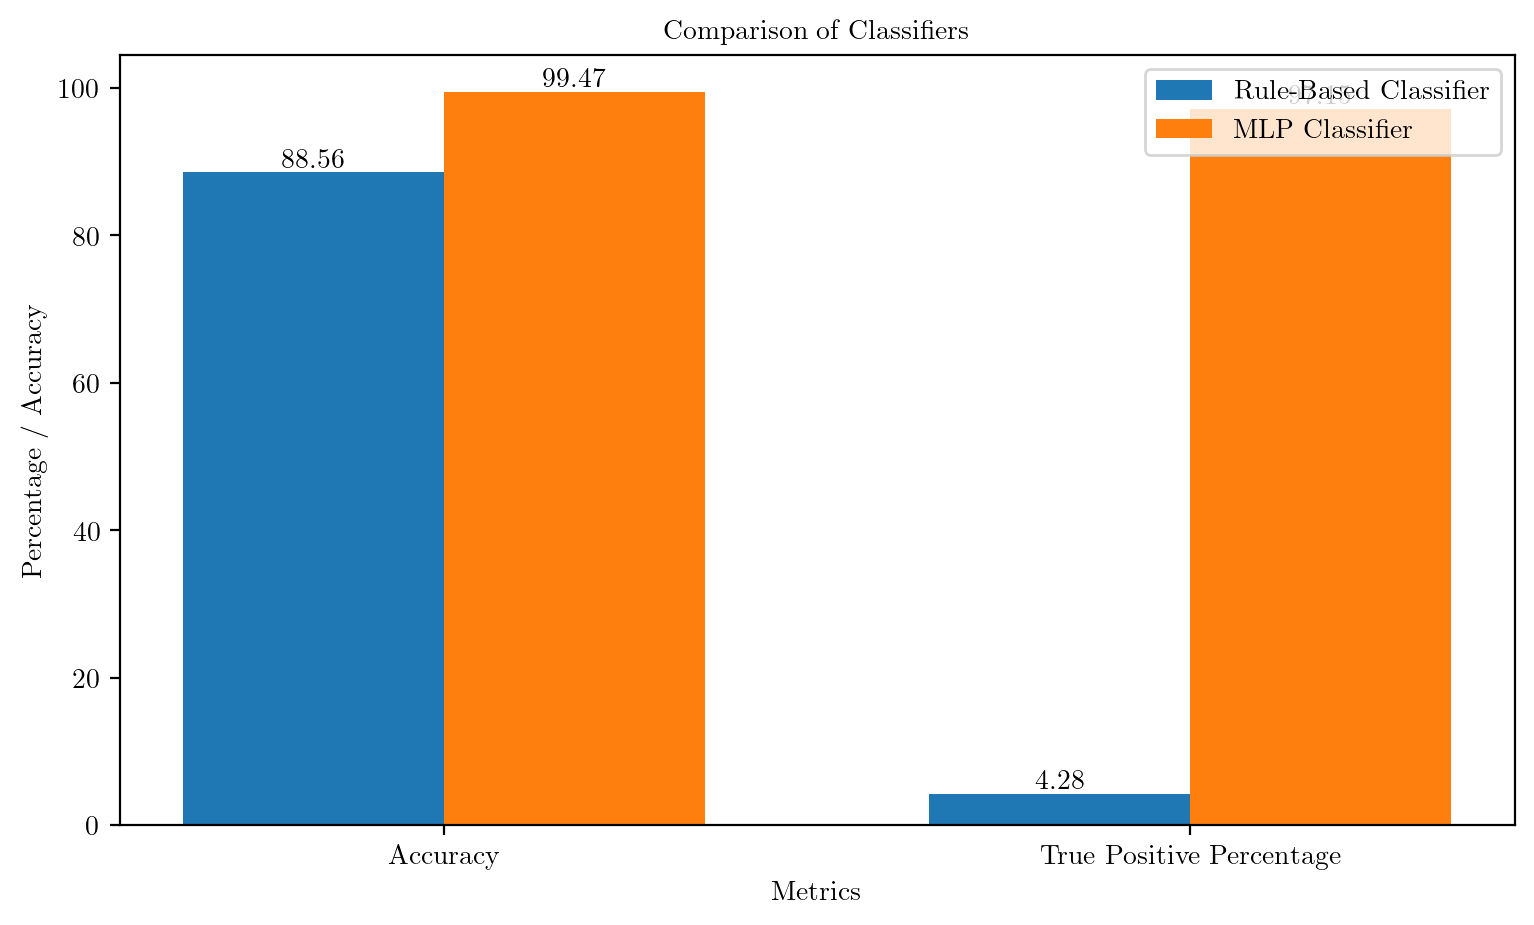

In [29]:
# Categories for the bar plot
categories = ['Accuracy', 'True Positive Percentage']

# Values for the rule-based classifier
rule_based_values = [accuracy_rule, percentage_TP_rule]

# Values for the MLP classifier
mlp_values = [accuracy_ML, percentage_TP_ML]

# Bar width
bar_width = 0.35

# X-axis positions for the bars
index = range(len(categories))

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(9, 5))
bar1 = ax.bar(index, rule_based_values, bar_width, label='Rule-Based Classifier')
bar2 = ax.bar([i + bar_width for i in index], mlp_values, bar_width, label='MLP Classifier')

# Adding labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage / Accuracy')
ax.set_title('Comparison of Classifiers')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

# Display the values on top of the bars
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Show the plot
plt.show()